_Version log: Branch of V19. Parameter scan accross number of pixels._

In [48]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, ndimage as spimg
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [49]:
#########FUNCTIONS INCLUDING COMPRESSED SENSING###########

def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [50]:
#############SIMULATED ANNEALLING#############

def simulated_annealling(target, detectors, regularization_coeffient, iterations = 5000, max_temp= 100, cooling= 0.99):

    #########INITAILISATION##########
    total_points = len(target)
    reduced_points = len(detectors)
    scores = np.array([])
    temps = []
    result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
    score = np.linalg.norm(target -result)
    target_temp = max_temp
    improvement = True

    #######START SIMULATED ANNEALLING###########
    for n in tqdm(range(iterations)):
        valid_vector_found = False

        while not valid_vector_found:
            temprature = target_temp
            random_vector = np.random.rand(reduced_points) -0.5
            random_vector /= np.linalg.norm(random_vector)
            random_step = random_vector *temprature
            new_detectors = np.round(detectors +random_step).astype(int)

            while 0 < temprature:
                bounds = np.concatenate([0 <= new_detectors, new_detectors < total_points, np.diff(new_detectors) > 0]) #, new_detectors != detectors]) #The last requirement that the new detectors must not be the same as the old ones makes it much slower.
                if np.all(bounds):
                    valid_vector_found = True
                    break
                temprature -= 0.2
                random_step = random_vector *temprature
                new_detectors = np.round(detectors +random_step).astype(int)

        new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
        new_score = np.linalg.norm(target -new_result)

        if new_score < score:
            detectors = new_detectors
            result = new_result
            score = new_score
            improvement = True

        if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
            target_temp = max_temp
            improvement = False
        elif improvement: #When hot, stop exploring and start optimising this regime.
            target_temp *= cooling

        scores = np.append(scores, score)
        temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors)]]

    temps = np.array(temps).T

    return result, scores, temps

In [51]:
file_name = "1dmock3"
file_type = ".csv"
subsample_percentage = 0.1
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [52]:
###################### THIS WILL TAKE A LONG TIME!!! (hours?) #################

total_points = [[20*n]*5 for n in range(1,17)]
total_points = np.array(total_points).flatten()

image = open_dataset(file_name, file_type)
results= np.array([])
best_scores = np.array([])


for total_point in total_points:

    compression = total_point /len(image)
    target = spimg.zoom(image, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    detectors = subsample_1d(total_point, subsample_percentage, "regular")

    result, scores, temps = simulated_annealling(target, detectors, regularization_coeffient, iterations = 5000, max_temp= 100, cooling= 0.99)
    
    #results = np.append(results, result)
    best_scores = np.append(best_scores, np.min(scores))

  0%|          | 5/5000 [00:00<01:41, 49.02it/s]

100%|██████████| 5000/5000 [01:37<00:00, 51.48it/s] 


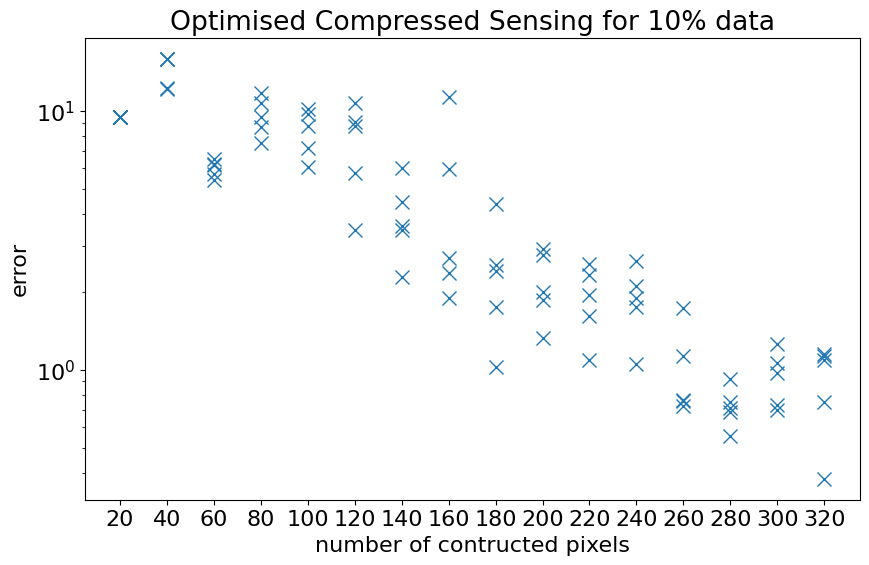

In [78]:
fig, axs = plt.subplots(figsize= (10,6))

axs.plot(total_points, best_scores, linestyle= "None", marker= "x", markersize= 10)
axs.set(xlabel= "number of contructed pixels",
        ylabel= "error",
        title= "Optimised Compressed Sensing for {:d}% data".format(round(subsample_percentage*100)),
        xticks= [20*n for n in range(1,17)],
        yscale= "log")

#plt.savefig("graphs\\error2pixelslogscale")

plt.show()

In [59]:
np.savetxt("data\\error2pixels.csv", np.array([total_points, best_scores]), delimiter=",")